In [ ]:
import numpy as np
from scipy import signal
import scipy.ndimage

def get_deconve_mask(W, layer_names, SRC, depth):
	''' 
	This function returns the deconvolved mask.

	W: weights. shape: (#conv_layers -by- #channels_out - #channels_in - #rows - #cols)
	layer_names: array of layer names from keras
	SRC: STFT representation 
	depth : integer, 0,1,2,3,.. if it's 5, and if there were 5 conv-MP layers, it will deconve from the deepest (i.e. the highest-level feature)

	'''
	def relu(x):
		return np.maximum(0., x)

	def get_deconvolve(images, weights):
		''' input image is expected to be unpooled image, i.e. 'upsampled' with switch matrix. 
		weights: 4-d array. (#channels_out - #channels_in - #rows - #cols) e.g. 64-64-3-3. 
		         When deconvolve, 'out' is input of deconvolution and vice versa. 
		         Check the names below: 'num_before_deconv' and 'num_after_deconv', which are self-explanatory 
		'''
		num_before_deconv, num_after_deconv, num_row, num_col = weights.shape
		flipped_weights = weights[:, :, ::-1, ::-1] # fliplr and flipud to use in deconvolution.
		reversed_flipped_weights = np.zeros((num_after_deconv, num_before_deconv, num_row, num_col))
		for dim0 in range(num_after_deconv): # reverse the dimension to reuse get_convolve function.
			for dim1 in range(num_before_deconv):
				reversed_flipped_weights[dim0, dim1, :, :] = flipped_weights[dim1, dim0, :, :]
		
		return get_convolve(images, reversed_flipped_weights)

	def get_unpooling2d(images, switches, ds=2):
		'''input imge size is (almost) half of switch'''
		num_image, num_img_row, num_img_col = images.shape
		num_switch, num_swt_row, num_swt_col = switches.shape
		# out_images = np.zeros((num_image, num_row*ds, num_col*ds))
		out_images = np.zeros((num_image, num_swt_row, num_swt_col))
		for ind_image, image in enumerate(images):
			out_images[ind_image, :num_img_row*ds, :num_img_col*ds] = np.multiply(scipy.ndimage.zoom(image, ds, order=0), switches[ind_image, :num_img_row*ds, :num_img_col*ds]) # [1 ] becomes [1 1; 1 1], then multiplied.
		return out_images

	def get_convolve(images, weights):
		''' images: 3-d array, #channel-#rows-#cols e.g. (1,257,173)
			weights: 4-d array, (#channels_out - #channels_in - #rows - #cols) e.g. (64,1,3,3) for the first convolution
		'''
		num_out, num_in, num_row_w, num_col_w = weights.shape
		num_row_img, num_col_img = images.shape[1], images.shape[2]
		out_images = np.zeros((num_out, num_row_img, num_col_img))
		
		for ind_input_layer in range( weights.shape[1] ):
			for ind_output_layer in range( weights.shape[0] ):
				
				out_images[ind_output_layer, :, :] += signal.convolve2d(images[ind_input_layer, :, :], weights[ind_output_layer, ind_input_layer, :, :], mode='same')

		return out_images

	def get_MP2d(images, ds=2):
		''' 
		images: 3-d array, #channel-#rows-#cols e.g. (1,257,173)
		ds = integer, which downsample by. e.g. 2
		return: result and switch
		    result: downsampled images (with 2d MAX)
		    switch: list of switch matrix; that showing from which position each 'max' values come.

		* ignore_border = True is assumed.
		'''
		
		num_image, num_row, num_col = images.shape
		out_images = np.zeros((num_image, int(num_row/ds), int(num_col/ds)))
		switch = np.zeros((num_image, num_row, num_col))
		
		for ind_image, image in enumerate(images):
			for row_ind in range(int(num_row/ds)):
				for col_ind in range(int(num_col/ds)):
					out_images[ind_image, row_ind, col_ind] = np.max( image[ds*row_ind:ds*row_ind+ds, ds*col_ind:ds*col_ind+ds] )
					argmax_here = 						   np.argmax( image[ds*row_ind:ds*row_ind+ds, ds*col_ind:ds*col_ind+ds] )
					switch[ind_image, ds*row_ind+int(argmax_here/ds), ds*col_ind+argmax_here%ds] = 1

		return out_images, switch

	'''function body of get_deconve_mask begins here.'''
	MAG = []
	MAG.append( np.zeros((1, SRC.shape[0], SRC.shape[1])) )
	
	MAG[0][0,:,:] = np.abs((SRC))
	
	switch_matrices = []
	procedures = []
	conv_ind = 0
	mp_ind = 0
	
	# [1] feed-forward path.
	print('-------feed-forward-')
	for layer_ind, layer_name in enumerate(layer_names):
		if layer_name == "Convolution2D":
			MAG.append(relu(get_convolve(images=MAG[-1], weights=W[conv_ind])))
			procedures.append('conv')
			conv_ind += 1

		elif layer_name == "MaxPooling2D":
			result, switch = get_MP2d(images=MAG[-1], ds=2)
			MAG.append(result)
			procedures.append('MP')
			switch_matrices.append(switch)
			mp_ind += 1

		if mp_ind == depth:
			break;

		elif layer_name == "Flatten":
			break
	
	# [2] 'deconve' # numbers below come from vggnet5 model (when depth == 4).
	revMAG = list(reversed(MAG)) # len(revMAG)==9, revMAG[i].shape = (64,16,10), (64,32,21), (64,32,21), (64,64,43), (64,128,86),(64,128,86),(64,257,173),(1,257,173)
	revProc = list(reversed(procedures)) # len(revProc)==8, ['MP', 'conv', 'MP', 'conv', 'MP', 'conv', 'MP', 'conv']
	revSwitch = list(reversed(switch_matrices)) # len(revSwitch)==4, revSwitch[0].shape = (64, 32, 21), (64, 64, 43), (64, 128, 86), (64, 257, 173)
	revW = list(reversed(W)) #len(revW)==4, (64,64,3,3), (64,64,3,3), (64,64,3,3), (64,1,3,3)

	num_outputs = revMAG[0].shape[0] # number of channels in the layer we consider (layer at 'depth')
	
	deconved_final_results = np.zeros((num_outputs, SRC.shape[0], SRC.shape[1]))
	
	for ind_out in range(num_outputs): 
		# Init with values that only (ind_out)-th feature map be considered
		deconvMAG 				= [None]
		deconvMAG[0] 			= np.zeros((1, revMAG[0].shape[1], revMAG[0].shape[2]))
		deconvMAG[0][0, :, :] 	= revMAG[0][ind_out, :, :] # assign with the spectrogram at the Last stage (at 'depth'). 

		revSwitch_to_use 				= [None]*len(revSwitch)
		revSwitch_to_use[0] 			= np.zeros((1, revSwitch[0].shape[1], revSwitch[0].shape[2]))
		revSwitch_to_use[0][0, :, :] 	= revSwitch[0][ind_out, :, :]
		revSwitch_to_use[1:]			= revSwitch[1:]

		revW_to_use    		= [None] * len(revW)
		revW_to_use[0]		= np.zeros((1, revW[0].shape[1], revW[0].shape[2], revW[0].shape[3]))
		revW_to_use[0][0,:,:,:] = revW[0][ind_out, :, :, :] #only weights to yield (ind_out)-th feature map.
		revW_to_use[1:]			= revW[1:]

		# Go!
		print('-------feed-back- %d --' % ind_out)
		unpool_ind = 0
		deconv_ind = 0
		for proc_ind, proc_name in enumerate(revProc):
			if proc_name == 'MP':
				# print 'unpool: %d, %d' % (unpool_ind, proc_ind)
				deconvMAG.append(relu(get_unpooling2d(images=deconvMAG[proc_ind], switches=revSwitch_to_use[unpool_ind])))
				unpool_ind += 1

			elif proc_name == "conv":
				# print 'deconv: %d, %d' % (deconv_ind, proc_ind)
				deconvMAG.append(get_deconvolve(images=deconvMAG[proc_ind], weights=revW_to_use[deconv_ind]))
				deconv_ind += 1

		deconved_final_results[ind_out, :, :] = deconvMAG[-1][:,:,:]
	
	return deconved_final_results

def load_weights():
	''' Load keras config file and return W
	'''
	# import h5py
	# model_name = "vggnet5"
	# keras_filename = "/content/drive/MyDrive/ELEC576_FinalProject/vggnet5_local_keras_model_CNN_stft_11_frame_173_freq_257_folding_0_best.keras"
	
	# print('--- load model ---')
	
	# W = []
	# f = h5py.File(keras_filename)
	# for idx in range(f.attrs['nb_layers']):
	# 	key = 'layer_%d' % idx
	# 	if list(f[key].keys()) != []:
	# 		W.append(f[key]['param_0'][:,:,:,:])
	# 	if len(W) == 5:
	# 		break
	# layer_names = []
	# for idx in range(5):
	# 	layer_names.append('Convolution2D')
	# 	layer_names.append('MaxPooling2D')
	# layer_names.append('Flatten')
	
	# return W, layer_names

	import pickle

	with open('/content/drive/MyDrive/ELEC576_FinalProject/W_temp_mono.pickle', 'rb') as handle:
		W = pickle.load(handle)
	layer_names = []
	for idx in range(5):
		layer_names.append('Convolution2D')
		layer_names.append('MaxPooling2D')
	layer_names.append('Flatten')
	return W, layer_names

In [ ]:
print(layer_names)

['Convolution2D', 'MaxPooling2D', 'Flatten', 'Convolution2D', 'MaxPooling2D', 'Flatten', 'Convolution2D', 'MaxPooling2D', 'Flatten', 'Convolution2D', 'MaxPooling2D', 'Flatten', 'Convolution2D', 'MaxPooling2D', 'Flatten']


In [ ]:
#-*- coding: utf_8 -*-
import matplotlib
import pickle
import numpy as np
import os
import sys
import librosa
from imageio import imwrite
import soundfile as sf
import librosa.display

''' 2015-09-28 Keunwoo Choi
- [0] load cnn weights that is learned from keras (http://keras.io) - but you don't need to install it.
- [1] load a song file (STFT).
---[1-0] log_amplitude(abs(STFT))
-- [1-1] feed-forward the spectrogram,
--- [1-1-0]using NOT theano, just scipy and numpy on CPU. Thus it's slow.
-- [1-2] then 'deconve' using switch matrix for every convolutional layer.
-- [1-3] 'separate' or 'auralise' the deconved spectrogram using phase information of original signal.
- [2]listen up!
'''

if __name__ == "__main__":
	'''
	This is main body of program I used for the paper at ismir. 
	You need a keras model weights file with music files at the appropriate folder... In other words, it won't be executed at your computer.
	Just see the part after 
		print '--- deconve! ---'
	, where the deconvolution functions are used.

	'''
	# load learned weights
	W, layer_names = load_weights()
	num_conv_layer = len(W)

	# load files
	print('--- prepare files ---')
	filenames_src = ['airport_mono.wav', 'bus_mono.wav', 'metro_mono.wav']
	path_SRC = '/content/drive/MyDrive/ELEC576_FinalProject/src_scenes/'
	path_src = '/content/drive/MyDrive/ELEC576_FinalProject/src_scenes/'
	print('--- Please modify above to run on your file ---')
	filenames_SRC = []
	
	N_FFT = 512
	SAMPLE_RATE = 11025

	# get STFT of the files.
	for filename in filenames_src:
		song_id = filename.split('.')[0]
		if os.path.exists(path_SRC + song_id + '.npy'):
			pass
		else:
			src = librosa.load(os.path.join(path_src, filename), sr=SAMPLE_RATE, mono=True, duration=10.)[0]
			SRC = librosa.stft(src, n_fft=N_FFT, hop_length=int(N_FFT/2))
			print(SRC.shape)
			if SRC.shape[1] > 431:
				SRC = SRC[:, :431]
			elif SRC.shape[1] < 431:
				SRC = np.hstack((SRC, np.expand_dims(np.tile(SRC[:,-1], 431-SRC.shape[1]), axis=1)))
			np.save(path_SRC + song_id + '.npy', SRC)
		filenames_SRC.append(song_id + '.npy')

	# deconve
	depths = [4,3,2,1]
	for filename in filenames_SRC:
		song_id = filename.split('.')[0]
		SRC = np.load(path_SRC + filename)
		filename_out = '%s_a_original.wav' % (song_id)	
		if not os.path.exists(path_SRC + song_id):
			os.makedirs(path_src + song_id)	
		if not os.path.exists(path_SRC + song_id + '_img'):
			os.makedirs(path_src + song_id + '_img')
		# librosa.output.write_wav(path_src+ song_id + '/' + filename_out, librosa.istft(SRC, hop_length=N_FFT/2), sr=SAMPLE_RATE, norm=True)
		sf.write(path_src+ song_id + '/' + filename_out, librosa.istft(SRC, hop_length=int(N_FFT/2)), SAMPLE_RATE)

		for depth in depths:
			print('--- deconve! ---')
			deconvedMASKS = get_deconve_mask(W[:depth], layer_names, SRC, depth) # size can be smaller than SRC due to downsampling
			print('result; %d masks with size of %d, %d' % deconvedMASKS.shape)
			# for deconved_feature_ind, deconvedMASK_here in enumerate(deconvedMASKS[0:len(deconvedMASKS):6]):
			for deconved_feature_ind, deconvedMASK_here in enumerate(deconvedMASKS[:len(deconvedMASKS)]):
				MASK = np.zeros(SRC.shape)
				MASK[0:deconvedMASK_here.shape[0], 0:deconvedMASK_here.shape[1]] = deconvedMASK_here
				deconvedSRC = np.multiply(SRC, MASK)

				filename_out = '%s_deconved_from_depth_%d_feature_%d.wav' % (song_id, depth, deconved_feature_ind)
				sf.write(path_src+ song_id + '/' + filename_out, librosa.istft(deconvedSRC, hop_length=int(N_FFT/2)), SAMPLE_RATE)

				filename_img_out = 'spectrogram_%s_from_depth_%d_feature_%d.png' % (song_id, depth, deconved_feature_ind)
				img = librosa.display.specshow(librosa.amplitude_to_db(np.multiply(np.abs(SRC), MASK), ref=np.max))
				plt.imsave(path_src+song_id + '_img' + '/' + filename_img_out, np.flipud(img.get_array().reshape(SRC.shape).data))
				# imwrite(path_src+song_id + '_img' + '/' + filename_img_out , np.flipud(np.multiply(np.abs(SRC), MASK)))

				filename_img_out = 'filter_for_%s_from_depth_%d_feature_%d.png' % (song_id, depth, deconved_feature_ind)
				img = librosa.display.specshow(librosa.amplitude_to_db(MASK, ref=np.max))
				plt.imsave(path_src+song_id + '_img' + '/' + filename_img_out, np.flipud(img.get_array().reshape(SRC.shape).data))

In [ ]:
plt.imsave(path_src+song_id + '_img' + '/' + filename_img_out, np.flipud(img.get_array().reshape(SRC.shape).data))

In [ ]:
np.any(np.abs(np.flipud(img.get_array().reshape(SRC.shape).data)) < 0)

False

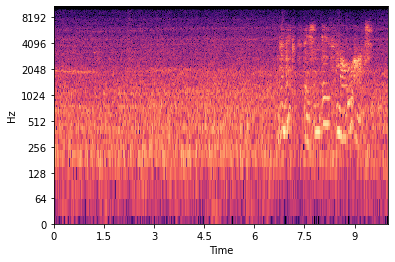

In [ ]:
filenames = ['airport_mono.wav', 'bus_mono.wav', 'metro_mono.wav']
filenames_img_out = ['airport_mono_SRC.png', 'bus_mono_SRC.png', 'metro_mono_SRC.png']

for i in range(len(filenames)):
  src = librosa.load(os.path.join(path_src, filenames[i]), sr=SAMPLE_RATE, mono=True, duration=10.)[0]
  SRC = librosa.stft(src, n_fft=N_FFT, hop_length=int(N_FFT/2))
  if SRC.shape[1] > 431:
    SRC = SRC[:, :431]
  elif SRC.shape[1] < 431:
    SRC = np.hstack((SRC, np.expand_dims(np.tile(SRC[:,-1], 431-SRC.shape[1]), axis=1)))
  img = librosa.display.specshow(librosa.amplitude_to_db(SRC, ref=np.max), y_axis='log', x_axis='time')
  # imwrite(path_src + '/' + filenames_img_out[i], np.flipud(img.get_array().reshape(SRC.shape).data))
  plt.imsave(path_src + '/' + filenames_img_out[i], np.flipud(img.get_array().reshape(SRC.shape).data), cmap='plasma')

(257, 172)


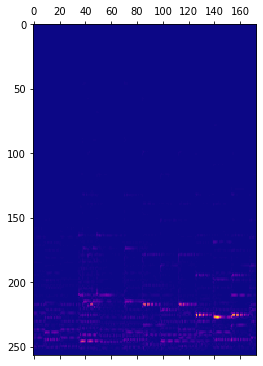

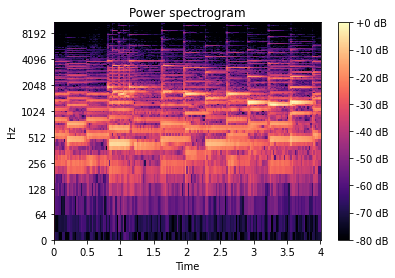

In [ ]:
import librosa.display
SRC = np.load(path_SRC + 'bach' + '.npy')
plt.matshow(np.flipud(np.abs(SRC)), cmap='plasma')

src = librosa.load(os.path.join(path_src, 'bach.wav'), sr=SAMPLE_RATE, mono=True, duration=4.)[0]
SRC = librosa.stft(src, n_fft=N_FFT, hop_length=int(N_FFT/2))
print(SRC.shape)
if SRC.shape[1] > 173:
  SRC = SRC[:, :173]
elif SRC.shape[1] < 173:
  SRC = np.hstack((SRC, np.expand_dims(np.tile(SRC[:,-1], 173-SRC.shape[1]), axis=1)))
# plt.matshow(np.flipud(np.abs(SRC)), cmap='plasma')
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(SRC, ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# plt.savefig(path_src + '/' + filenames_img_out[i], np.flipud(np.abs(SRC)), cmap='plasma')

0.021188510999991195
0.03227155399997628


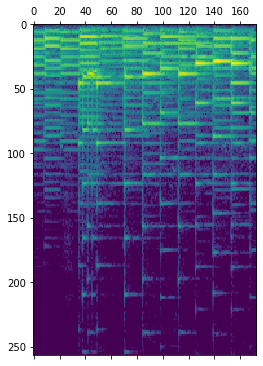

In [ ]:
import time
plt.matshow(img.get_array().reshape(SRC.shape).data)
start = time.process_time()
imwrite(path_src + '/' + 'bach_SRC1.png', np.flipud(img.get_array().reshape(SRC.shape).data))
print(time.process_time() - start)